In [3]:
import numpy as np
np.bool = np.bool_
np.complex = np.complex128
import torch
from aug.automold import add_rain, add_snow, add_fog, add_autumn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tt
from diffusers.utils import make_image_grid
from models import ResNet
from PIL import Image
from tqdm.notebook import tqdm
import cv2
import random
import os
import torchvision

/home/satyam/Desktop/domain_adaptation/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_stl10(root_dir: str = "stl10_binary"):

    path_to_images = os.path.join(root_dir, "train_X.bin")
    path_to_labels = os.path.join(root_dir, "train_y.bin")
    
    with open(path_to_images, 'rb') as f:
        images = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(images, (-1, 3, 96, 96))
        train_images = np.transpose(images, (0, 3, 2, 1))
    
    with open(path_to_labels, 'rb') as f:
        train_labels = np.fromfile(f, dtype=np.uint8) - 1
    
    path_to_images = os.path.join(root_dir, "test_X.bin")
    path_to_labels = os.path.join(root_dir, "test_y.bin")
    
    with open(path_to_images, 'rb') as f:
        images = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(images, (-1, 3, 96, 96))
        test_images = np.transpose(images, (0, 3, 2, 1))
    
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        test_labels = labels - 1

    return train_images, train_labels, test_images, test_labels

def add_snow(image, snowflake_count=200, snowflake_radius=(1, 3), snowflake_intensity=(200, 255)):
    snowy_image = image.copy()
    height, width, _ = snowy_image.shape
    for _ in range(snowflake_count):
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)
        
        radius = np.random.randint(snowflake_radius[0], snowflake_radius[1])
        intensity = np.random.randint(snowflake_intensity[0], snowflake_intensity[1])
        
        cv2.circle(snowy_image, (x, y), radius, (intensity, intensity, intensity), -1)

    return snowy_image

def shift(image, domain):
    if domain == "rain":
        return add_rain(image, rain_type = 'torrential')
    elif domain == "fog":
        return add_fog(image, fog_coeff=1.0)
    elif domain == "snow":
        return add_snow(image=image)
    elif domain == "autumn":
        return add_autumn(image)
    return image

class STL10Dataset(Dataset):
    def __init__(self, images, labels, domain="base"):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)
        self.domain = domain
        self.domains = ["rain", "fog", "snow"]
        stats = ((113.911194, 112.1515, 103.69485), (51.854874, 51.261967, 51.842403))
        self.tfms = tt.Compose([
            tt.ToTensor(),
            tt.Normalize(stats[0], stats[1])
        ])

    def __len__(self):
        if self.domain == "all":
            return len(self.domains) * len(self.images)
        return len(self.images)

    def __getitem__(self, idx):

        if self.domain == "all":
            d = idx // len(self.images)
            idx = idx % len(self.images)
            domain = self.domains[d]
        else:
            domain = self.domain
        
        image = self.images[idx]
        label = self.labels[idx]

        image = shift(image, domain)
        
        image[np.isnan(image)] = 0

        image = self.tfms(image)

        return image, label

def evaluate(model, batch_size, num_workers, domains, device, dtype):
    
    train_images, train_labels, test_images, test_labels = load_stl10()
    criterion = torch.nn.CrossEntropyLoss()

    model.eval()
    model.to(device).to(dtype)
    result = {}

    for domain in domains:
        
        test_dataset = STL10Dataset(test_images, test_labels, domain=domain)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        total_loss = 0
        total = 0
        correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                inputs, labels = images.to(device).to(dtype), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        result[domain] = {
            "loss": total_loss / total,
            "accuracy": correct / total
        }

    return result

In [4]:
import torchvision
import torch

device = "cuda:7"
dtype = torch.float32

def load_model(model_name):
    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    model.fc = torch.nn.Linear(model.fc.in_features, 10)
    model.load_state_dict(torch.load(f"./ckpts/{model_name}.pth"))
    model.to(device).to(dtype)
    return model

def get_empty_state():
    result = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    result.fc = torch.nn.Linear(result.fc.in_features, 10)
    result.to(device).to(dtype)
    result_state = result.state_dict()
    for k, v in result_state.items():
        result_state[k] = torch.zeros_like(v)
    return result_state

def get_empty_model():
    result = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    result.fc = torch.nn.Linear(result.fc.in_features, 10)
    result.to(device).to(dtype)
    return result

base = load_model("resnet_50")
mtl = load_model("mtl")

for domain in ["rain", "fog", "snow"]:

    mask = torch.load(f"./ckpts/mask_{domain}.pth")
    state = get_empty_state()
    for key in state:
        state[key] = base.state_dict()[key] + mask[key].to(device).to(dtype) * mtl.state_dict()[key]
    model = get_empty_model()
    model.load_state_dict(state)
    
    result = evaluate(
        base,
        batch_size = 256,
        num_workers = 8,
        domains = [domain],
        device = device,
        dtype = dtype
    )
    print(f"Accuracy: {result[domain]['accuracy'] * 100:.4f}% on domain {domain}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/satyam/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
 87%|████████▋ | 85.0M/97.8M [00:08<00:01, 11.1MB/s]


KeyboardInterrupt: 

Ground Truth class: horse
Predicted class: horse             Predicted class: deer             Predicted class: horse


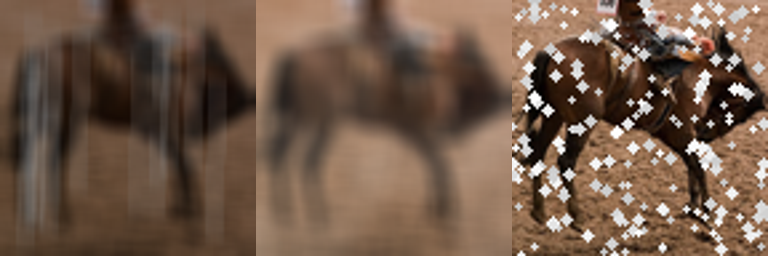

In [55]:
import matplotlib.pyplot as plt

train_images, train_labels, test_images, test_labels = load_stl10()

idx = np.random.randint(0, test_images.shape[0])
# idx = 2645
device = "cuda:7"
dtype = torch.float32

base = load_model("resnet_50")
mtl = load_model("mtl")

label = test_labels[idx].astype(np.int64)

stats = ((113.911194, 112.1515, 103.69485), (51.854874, 51.261967, 51.842403))
tfms = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(stats[0], stats[1])
])

classes = np.array([
    'airplane',
    'bird',
    'car',
    'cat',
    'deer',
    'dog',
    'horse',
    'monkey',
    'ship',
    'truck'
])

images = []
gts = []
preds = []

for domain in ["rain", "fog", "snow"]:
    image = test_images[idx].astype(np.float32)
    image = shift(image, domain)
    image[np.isnan(image)] = 0
    
    img = tfms(image).unsqueeze(0)
    
    mask = torch.load(f"./ckpts/mask_{domain}.pth")
    state = get_empty_state()
    for key in state:
        state[key] = base.state_dict()[key] + mask[key].to(device).to(dtype) * mtl.state_dict()[key]
    model = get_empty_model()
    model.load_state_dict(state)
    model.to(device).to(dtype)
    model.eval()
    
    with torch.no_grad():
        outputs = model(img.to(device).to(dtype))
    
    images.append(Image.fromarray(image.astype(np.uint8)).resize((256, 256)))
    gts.append(classes[label])
    preds.append(classes[outputs.argmax().item()])

print(f"Ground Truth class: {gts[0]}")
print("             ".join([f"Predicted class: {c}" for c in preds]))
make_image_grid(images, rows=1, cols=3)

In [43]:
# 2645 -> cat
# 1111 -> deer

In [ ]:
Image.fromarray(image.astype(np.uint8)).resize((96, 96)).save("samples/6622.png")

In [ ]:
evaluate(
    model,
    batch_size = 256,
    num_workers = 8,
    domains = [domain],
    device = device,
    dtype = dtype
)